In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="7"

In [3]:
import torch
from cephdataset import *

In [4]:
from train.pretrain import *
from train.pretrain import get_args
from mltool.universal_model_util import get_model_para_detail
import numpy as np

In [5]:
ckpt_path = "checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_14_14_35_54249-seed_73001"
args=get_args(os.path.join(ckpt_path,"config.json"))

In [6]:
args.use_wandb=0
args.gpu = args.local_rank = gpu  = local_rank = 0
##### parse args: dataset_kargs / model_kargs / train_kargs  ###########
args= parse_default_args(args)
SAVE_PATH = get_ckpt_path(args)
SAVE_PATH = "debug"
args.SAVE_PATH = str(SAVE_PATH)
#args.pretrain_weight = os.path.join(args.SAVE_PATH,'pretrain_latest.pt')
########## inital log ###################
logsys = create_logsys(args,False)
args.distributed = False

if args.distributed:
    if args.dist_url == "env://" and args.rank == -1:
        args.rank = int(os.environ["RANK"])
    if args.multiprocessing_distributed:
        # For multiprocessing distributed training, rank needs to be the
        # global rank among all the processes
        args.rank = args.rank * ngpus_per_node + local_rank
    logsys.info(f"start init_process_group,backend={args.dist_backend}, init_method={args.dist_url},world_size={args.world_size}, rank={args.rank}")
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,world_size=args.world_size, rank=args.rank)

model           = build_model(args)
#param_groups    = timm.optim.optim_factory.add_weight_decay(model, args.weight_decay)
optimizer,lr_scheduler,criterion = build_optimizer(args,model)
loss_scaler     = torch.cuda.amp.GradScaler(enabled=True)
logsys.info(f'use lr_scheduler:{lr_scheduler}')

2023-01-15 21:46:46,487 model args: img_size= (32, 64)
2023-01-15 21:46:46,488 model args: patch_size= 2


log at debug
wandb id: None
wandb is off, the recorder list is  ['tensorboard'], we pass wandb


2023-01-15 21:46:46,911 use model ==> AFNONet
2023-01-15 21:46:46,913 Rank: 0, Local_rank: 0 | Number of Parameters: 46754303, Number of Buffers: 0, Size of Model: 178.3535 MB

2023-01-15 21:46:48,580 use lr_scheduler:<timm.scheduler.cosine_lr.CosineLRScheduler object at 0x7f1b2a5474f0>


In [7]:
pretrain_path = os.path.join(ckpt_path,"pretrain_latest.pt")
args.pretrain_weight = pretrain_path

In [8]:
logsys.info(f"loading weight from {args.pretrain_weight}")
start_epoch, start_step, min_loss = load_model(model.module if args.distributed else model, optimizer, lr_scheduler, loss_scaler, path=args.pretrain_weight, 
                    only_model= (args.mode=='fourcast') or (args.mode=='finetune' and not args.continue_train) ,loc = 'cuda:{}'.format(args.gpu))
if args.more_epoch_train:
    assert args.pretrain_weight
    print(f"detect more epoch training, we will do a copy processing for {args.pretrain_weight}")
    os.system(f'cp {args.pretrain_weight} {args.pretrain_weight}-epoch{start_epoch}')
logsys.info("done!")

2023-01-15 21:46:54,094 loading weight from checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_14_14_35_54249-seed_73001/pretrain_latest.pt


loading model from checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_14_14_35_54249-seed_73001/pretrain_latest.pt...........


2023-01-15 21:46:54,571 done!


loading model weight success...........
loading optimizer weight success...........
loading lr_scheduler weight success...........
loading loss_scaler weight success...........
loading model success...........


#### test

In [9]:
args.valid_batch_size = 1
test_dataset,  test_dataloader = get_test_dataset(args,test_dataset_tensor=None,test_record_load=None)

use offline data mode <2>: train/valid/test use offline data
use dataset in datasets/weatherbench_6hour
load data from datasets/weatherbench_6hour/test_2D70N.npy


In [10]:
data_loader = test_dataloader
random_repeat = 0
snap_index=None
model.eval()
logsys.eval()
status     = 'test'
gpu        = dist.get_rank() if hasattr(model,'module') else 0
Fethcher   = Datafetcher
prefetcher = Fethcher(data_loader,next(model.parameters()).device)
batches = len(data_loader)
inter_b    = logsys.create_progress_bar(batches,unit=' img',unit_scale=data_loader.batch_size)
device = next(model.parameters()).device
data_cost = train_cost = rest_cost = 0
now = time.time()
model.clim = torch.Tensor(data_loader.dataset.clim_tensor).to(device)
fourcastresult={}
save_prediction_first_step = None#torch.zeros_like(data_loader.dataset.data)
save_prediction_final_step = None#torch.zeros_like(data_loader.dataset.data)
# = 100
intervel = batches//logsys.log_trace_times + 1

with torch.no_grad():
    inter_b.lwrite("load everything, start_validating......", end="\r")
    while inter_b.update_step():
        #if inter_b.now>10:break
        data_cost += time.time() - now;now = time.time()
        step        = inter_b.now
        idxes,batch = prefetcher.next()
        batch       = make_data_regular(batch,half_model)
        break

In [12]:
len(batch)

22

In [14]:
model.iscuda()

AttributeError: 'AFNONet' object has no attribute 'iscuda'

In [23]:
model_weight_1= "checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_14_14_35_54249-seed_73001/pretrain_latest.pt"
model_weight_2= "checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_07_18_12-seed_73001/pretrain_latest.pt"

In [25]:
model.load_state_dict(torch.load(model_weight_2)['model'])
model = model.cuda()

In [26]:
with torch.no_grad():
    pred1_best = model(batch[0])
    pred2_best = model(pred1_best)

In [30]:
with torch.no_grad():
    pred2_new = model(pred1)

In [19]:
real = batch[1]

In [28]:
torch.mean((pred1 - batch[1])**2)

tensor(0.0284, device='cuda:0')

In [ ]:
(pred1 - pred1_best)

In [37]:
14*32

448

In [38]:
5*64

320

In [47]:
errortable = ((pred1 - pred1_best)/pred1_best).reshape(5,14,32,64).permute(1,2,0,3).reshape(14*32,5*64).cpu().numpy()

In [39]:
from mltool.visualization import *

In [51]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=[go.Surface(z=errortable)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

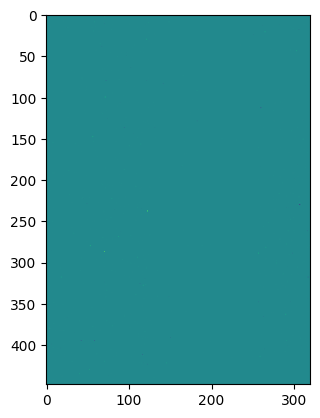

In [48]:
%matplotlib inline

plt.imshow(errortable)

In [32]:
print(torch.mean((pred1      - batch[1])**2))
print(torch.mean((pred1_best - batch[1])**2))


tensor(0.0292, device='cuda:0')
tensor(0.0284, device='cuda:0')


In [33]:
print(torch.mean((pred2 - batch[2])**2))
print(torch.mean((pred2_best - batch[2])**2))
print(torch.mean((pred2_new - batch[2])**2))

tensor(0.7211, device='cuda:0')
tensor(0.0437, device='cuda:0')
tensor(0.0424, device='cuda:0')


In [10]:
dataset = data_loader.dataset
time_step_1_mode = False

In [11]:
start = batch[0:model.history_length]
for i in range(model.history_length,len(batch), model.pred_len):# i now is the target index
    end = batch[i:i+model.pred_len]
    end = end[0] if len(end) == 1 else end
    break
    #ltmv_pred, target, extra_loss, extra_info_from_model_list, start = once_forward(model,i,start,end,dataset,time_step_1_mode)
   

In [12]:
tensor, start_time_stamp, start_pos = [torch.stack([s[i] for s in start],1) for i in range(len(start[-1]))] 
target,   end_time_stamp,   end_pos =  [torch.stack([s[i] for s in   end],1) for i in range(len(  end[-1]))] 

In [19]:
model = POverLapTimePosFEDformer(**args.model_kargs)
model = model.cuda()
_=model.eval()

for 2D patch model, the img_size will be force set (32,64)
fourier enhanced block used!
for shape:[7 7] and pick modes:(7, 7)>=25.0, we pick 25.0 modes, the baseline modes is 25.0
create a mode filter shape=torch.Size([7, 7, 15]) with 200 mode activate
fourier enhanced block used!
for shape:[7 7] and pick modes:(7, 7)>=25.0, we pick 25.0 modes, the baseline modes is 25.0
create a mode filter shape=torch.Size([7, 7, 6]) with 150 mode activate
 fourier enhanced cross attention used!
for shape:[7 7] and pick modes:(7, 7)>=25.0, we pick 25.0 modes, the baseline modes is 25.0
for shape:[7 7] and pick modes:(7, 7)>=25.0, we pick 25.0 modes, the baseline modes is 25.0
 modes_q=150,  shape_q=torch.Size([7, 7, 6])
modes_kv=200, shape_kv=torch.Size([7, 7, 15])


In [14]:
with torch.no_grad():
    out   = model(tensor, start_pos,start_time_stamp,end_time_stamp) #(B,T,P,W,H) (B,T,4) (B,T,2,W,H)

In [11]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [14]:
import copy

In [21]:
the_lsit = []
for subset in (powerset("01234")):
    if len(subset)<2:continue
    if len(subset)==5:continue
    for i in range(len(subset)):
        input_property = list(copy.deepcopy(subset))
        output_property = input_property.pop(i)
        name1 = ",".join(input_property)
        name2 = ",".join(output_property)
        flag = f"'{name1}.{name2}'"
        the_lsit.append(flag)
        print(flag,end=",")

'1.0','0.1','2.0','0.2','3.0','0.3','4.0','0.4','2.1','1.2','3.1','1.3','4.1','1.4','3.2','2.3','4.2','2.4','4.3','3.4','1,2.0','0,2.1','0,1.2','1,3.0','0,3.1','0,1.3','1,4.0','0,4.1','0,1.4','2,3.0','0,3.2','0,2.3','2,4.0','0,4.2','0,2.4','3,4.0','0,4.3','0,3.4','2,3.1','1,3.2','1,2.3','2,4.1','1,4.2','1,2.4','3,4.1','1,4.3','1,3.4','3,4.2','2,4.3','2,3.4','1,2,3.0','0,2,3.1','0,1,3.2','0,1,2.3','1,2,4.0','0,2,4.1','0,1,4.2','0,1,2.4','1,3,4.0','0,3,4.1','0,1,4.3','0,1,3.4','2,3,4.0','0,3,4.2','0,2,4.3','0,2,3.4','2,3,4.1','1,3,4.2','1,2,4.3','1,2,3.4',

In [22]:
len(the_lsit)

70

In [15]:
enumerate

torch.Size([1, 7, 70, 32, 64])

#### train

In [ ]:
#args.dataset_kargs['cross_sample']=args.cross_sample=0

In [25]:
args.dataset_kargs['batch_size']=args.batch_size = 1

In [26]:
args.dataset_kargs['cross_sample']=args.cross_sample=0

In [27]:
args.dataset_kargs['use_offline_data']=2

In [31]:
args.dataset_kargs['patch_range']=(3,5,5)

In [32]:
train_dataset, val_dataset, train_dataloader,val_dataloader = get_train_and_valid_dataset(args,
               train_dataset_tensor=None,train_record_load=None,
               valid_dataset_tensor=None,valid_record_load=None)
logsys.info(f"use dataset ==> {train_dataset.__class__.__name__}")
logsys.info(f"Start training for {args.epochs} epochs")
master_bar = logsys.create_master_bar(args.epochs)
accu_list = ['valid_loss']
metric_dict = logsys.initial_metric_dict(accu_list)

use offline data mode <2>: train/valid/test use offline data
use dataset in datasets/weatherbench_6hour
load data from datasets/weatherbench_6hour/train_3D70N.npy
notice we will use around_index(12, 28, 64, 3, 3, 5, 5) to patch data
use offline data mode <2>: train/valid/test use offline data
use dataset in datasets/weatherbench_6hour
load data from datasets/weatherbench_6hour/valid_3D70N.npy
notice we will use around_index(12, 28, 64, 3, 3, 5, 5) to patch data


2022-12-17 15:13:29,781 use dataset ==> WeathBench7066PatchDataset
2022-12-17 15:13:29,782 Start training for 500 epochs


In [33]:
args.dataset_kargs['cross_sample']=args.cross_sample=1
train_dataset.cross_sample  =1
train_dataloader  = torch.utils.data.DataLoader(train_dataset,1)

In [34]:
train_dataset.cross_sample  =0
train_dataloader  = torch.utils.data.DataLoader(train_dataset,300)

In [ ]:
# val_dataset.cross_sample  =0 
# val_dataloader = torch.utils.data.DataLoader(val_dataset,256)

In [10]:
epoch = 0
start_step = 0
data_loader = train_dataloader
status = 'train'
if status == 'train':
    model.train()
    logsys.train()
elif status == 'valid':
    model.eval()
    logsys.eval()
else:
    raise NotImplementedError
accumulation_steps = model.accumulation_steps # should be 16 for finetune. but I think its ok.
half_model = next(model.parameters()).dtype == torch.float16

data_cost  = []
train_cost = []
rest_cost  = []
now = time.time()

Fethcher   = RandomSelectPatchFetcher if( status =='train' and \
                                          data_loader.dataset.use_offline_data and \
                                          data_loader.dataset.split=='train' and \
                                          'Patch' in data_loader.dataset.__class__.__name__) else Datafetcher
device     = next(model.parameters()).device
prefetcher = Fethcher(data_loader,device)
#raise
batches    = len(data_loader)

inter_b    = logsys.create_progress_bar(batches,unit=' img',unit_scale=data_loader.batch_size)
gpu        = dist.get_rank() if hasattr(model,'module') else 0

if start_step == 0:optimizer.zero_grad()
intervel = batches//100 + 1


total_diff,total_num  = torch.Tensor([0]).to(device), torch.Tensor([0]).to(device)
nan_count = 0
Nodeloss1 = Nodeloss2 = Nodeloss12 = -1

inter_b.lwrite(f"load everything, start_{status}ing......", end="\r")
preds = []
reals = []

In [52]:
train_dataset.cross_sample  =0
train_dataloader  = torch.utils.data.DataLoader(train_dataset,1)

In [46]:
val_dataset.cross_sample  = 1
val_dataloader  = torch.utils.data.DataLoader(val_dataset,1)

In [12]:
model.accumulation_steps = 1

In [53]:
import time

In [41]:
def run_one_iter(model, batch, criterion, status, gpu, dataset):
    iter_info_pool={}
    loss = 0
    diff = 0
    random_run_step = np.random.randint(1,len(batch)) if len(batch)>1 else 0
    time_step_1_mode=False
    if len(batch) == 1 and isinstance(batch[0],(list,tuple)) and len(batch[0])>1:
        batch = batch[0] # (Field, FieldDt)
        time_step_1_mode=True
    if model.history_length > len(batch):
        print(f"you want to use history={model.history_length}")
        print(f"but your input batch(timesteps) only has len(batch)={len(batch)}")
        raise
    pred_step = 0
    start = batch[0:model.history_length] # start must be a list
    ltmv_pred_record = []
    target_record = []
    for i in range(model.history_length,len(batch)):# i now is the target index
        ltmv_pred, target, extra_loss, extra_info_from_model_list, start = once_forward(model,i,start,batch[i],dataset,time_step_1_mode)
        if extra_loss !=0:
            iter_info_pool[f'{status}_extra_loss_gpu{gpu}_timestep{i}'] = extra_loss.item()
        for extra_info_from_model in extra_info_from_model_list:
            for name, value in extra_info_from_model.items():
                iter_info_pool[f'valid_on_{status}_{name}_timestep{i}'] = value
        
        ltmv_pred = dataset.do_normlize_data([ltmv_pred])[0]

        abs_loss = criterion(ltmv_pred,target)
        ltmv_pred_record.append(ltmv_pred)
        target_record.append(target)
        iter_info_pool[f'{status}_abs_loss_gpu{gpu}_timestep{i}'] =  abs_loss.item()
        pred_step+=1
        loss += abs_loss + extra_loss
        diff += abs_loss
        if model.random_time_step_train and i >= random_run_step:
            break
    # loss = loss/(len(batch) - 1)
    # diff = diff/(len(batch) - 1)
    loss = loss/pred_step
    diff = diff/pred_step
    return loss, diff, iter_info_pool,torch.cat(ltmv_pred_record),torch.cat(target_record)

In [55]:
epoch = 0
start_step = 0
data_loader = train_dataloader
status = 'valid'
if status == 'train':
    model.train()
    logsys.train()
elif status == 'valid':
    model.eval()
    logsys.eval()
else:
    raise NotImplementedError
accumulation_steps = model.accumulation_steps # should be 16 for finetune. but I think its ok.
half_model = next(model.parameters()).dtype == torch.float16

data_cost  = []
train_cost = []
rest_cost  = []
now = time.time()

Fethcher   = RandomSelectPatchFetcher if( status =='train' and \
                                          data_loader.dataset.use_offline_data and \
                                          data_loader.dataset.split=='train' and \
                                          'Patch' in data_loader.dataset.__class__.__name__) else Datafetcher
device     = next(model.parameters()).device
prefetcher = Fethcher(data_loader,device)
#raise
batches    = len(data_loader)

inter_b    = logsys.create_progress_bar(batches,unit=' img',unit_scale=data_loader.batch_size)
gpu        = dist.get_rank() if hasattr(model,'module') else 0

if start_step == 0:optimizer.zero_grad()
intervel = batches//100 + 1


total_diff,total_num  = torch.Tensor([0]).to(device), torch.Tensor([0]).to(device)
nan_count = 0
Nodeloss1 = Nodeloss2 = Nodeloss12 = -1

inter_b.lwrite(f"load everything, start_{status}ing......", end="\r")
preds = []
reals = []
while inter_b.update_step():
    #if inter_b.now>10:break
    step = inter_b.now
    batch = prefetcher.next()
    #print(batch[0].shape)
    #raise
    if step < start_step:continue
    #batch = data_loader.dataset.do_normlize_data(batch)

    batch = make_data_regular(batch,half_model)
    
    
    #if len(batch)==1:batch = batch[0] # for Field -> Field_Dt dataset
    data_cost.append(time.time() - now);now = time.time()
    if status == 'train':
        if hasattr(model,'set_step'):model.set_step(step=step,epoch=epoch)
        if hasattr(model,'module') and hasattr(model.module,'set_step'):model.module.set_step(step=step,epoch=epoch)
        if model.train_mode =='pretrain':
            time_truncate = max(min(epoch//3,data_loader.dataset.time_step),2)
            batch=batch[:model.history_length -1 + time_truncate]

        # the normal initial method will cause numerial explore by using timestep > 4 senenrio.
        if model.use_amp:
            with torch.cuda.amp.autocast():
                loss, abs_loss, iter_info_pool =run_one_iter(model, batch, criterion, 'train', gpu, data_loader.dataset)
        else:
            loss, abs_loss, iter_info_pool =run_one_iter(model, batch, criterion, 'train', gpu, data_loader.dataset)
        loss, nan_count, skip = nan_diagnose_weight(model,loss,nan_count,logsys)
        if skip:continue
        loss /= accumulation_steps

        if model.use_amp:
            loss_scaler.scale(loss).backward()
        else:
            loss.backward()

        if model.clip_grad:
            if model.use_amp:
                assert accumulation_steps == 1
                loss_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), model.clip_grad)

        if (step+1) % accumulation_steps == 0:
            if model.use_amp:

                loss_scaler.step(optimizer)
                loss_scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
    else:
        with torch.no_grad():
            #print([p.shape for t in batch for p in t])
            loss, abs_loss, iter_info_pool,pred,real =run_one_iter(model, batch, criterion, status, gpu, data_loader.dataset)
    iter_info_pool={}
    iter_info_pool[f'{status}_loss_gpu{gpu}']     =  loss.item()
    iter_info_pool[f'{status}_Nodeloss1_gpu{gpu}'] = Nodeloss1
    iter_info_pool[f'{status}_Nodeloss12_gpu{gpu}'] = Nodeloss12
    iter_info_pool[f'{status}_Nodeloss2_gpu{gpu}'] = Nodeloss2
    total_diff  += abs_loss.item()
    #total_num   += len(batch) - 1 #batch 
    total_num   += 1 

    train_cost.append(time.time() - now);now = time.time()
    time_step_now = len(batch)
    outstring=(f"epoch:{epoch:03d} iter:[{step:5d}]/[{len(data_loader)}] [TimeLeng]:{time_step_now:} GPU:[{gpu}] abs_loss:{abs_loss.item():.2f} loss:{loss.item():.2f} cost:[Date]:{np.mean(data_cost):.1e} [Train]:{np.mean(train_cost):.1e} ")
    #print(data_loader.dataset.record_load_tensor.mean().item())
    data_cost  = []
    train_cost = []
    rest_cost = []
    inter_b.lwrite(outstring, end="\r")
    preds.append(pred.detach().cpu())
    reals.append(real.detach().cpu())

KeyboardInterrupt: 

In [ ]:
# for epoch in mastera_bar:
#     if epoch < start_epoch:continue
#     if hasattr(model,'set_epoch'):model.set_epoch(epoch=epoch,epoch_total=args.epochs)
#     if hasattr(model,'module') and hasattr(model.module,'set_epoch'):model.module.set_epoch(epoch=epoch,epoch_total=args.epochs)
#     logsys.record('learning rate',optimizer.param_groups[0]['lr'],epoch, epoch_flag='epoch')
#     train_loss = run_one_epoch(epoch, start_step, model, criterion, train_dataloader, optimizer, loss_scaler,logsys,'train')


NameError: name 'master_bar' is not defined

In [ ]:
train_dataset_tensor=None;
train_record_load=None;
valid_dataset_tensor=None;
valid_record_load=None

In [ ]:
# =======================> start training <==========================
print(f"entering {args.mode} training in {next(model.parameters()).device}")
now_best_path = SAVE_PATH / 'backbone.best.pt'
latest_ckpt_p = SAVE_PATH / 'pretrain_latest.pt'


train_dataset, val_dataset, train_dataloader,val_dataloader = get_train_and_valid_dataset(args,
               train_dataset_tensor=train_dataset_tensor,train_record_load=train_record_load,
               valid_dataset_tensor=valid_dataset_tensor,valid_record_load=valid_record_load)
logsys.info(f"use dataset ==> {train_dataset.__class__.__name__}")
logsys.info(f"Start training for {args.epochs} epochs")
metric_list = ['loss']
master_bar        = logsys.create_master_bar(args.epochs)
master_bar.set_multiply_graph(figsize=(9,3),engine=[['plot','plot']],labels=[metric_list])
for epoch in master_bar:
    if epoch < start_epoch:continue
    if hasattr(model,'set_epoch'):model.set_epoch(epoch=epoch,epoch_total=args.epochs)
    if hasattr(model,'module') and hasattr(model.module,'set_epoch'):model.module.set_epoch(epoch=epoch,epoch_total=args.epochs)
    logsys.record('learning rate',optimizer.param_groups[0]['lr'],epoch)
    train_loss = run_one_epoch(epoch, start_step, model, criterion, train_dataloader, optimizer, loss_scaler,logsys,'train')
    if (not args.more_epoch_train) and (lr_scheduler is not None):lr_scheduler.step(epoch)
    #torch.cuda.empty_cache()
    #train_loss = single_step_evaluate(train_dataloader, model, criterion,epoch,logsys,status='train') if 'small' in args.train_set else -1
    val_loss   = run_one_epoch(epoch, start_step, model, criterion, val_dataloader, optimizer, loss_scaler,logsys,'valid')

    if (not args.distributed) or (args.rank == 0 and local_rank == 0) :
        logsys.info(f"Epoch {epoch} | Train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}")
        logsys.record('train', train_loss, epoch)
        logsys.record('valid', val_loss, epoch)
        if use_wandb:wandb.log({"epoch":epoch,'train':train_loss,'valid':val_loss})
        if val_loss < min_loss:
            min_loss = val_loss
            if epoch > args.epochs//10:
                logsys.info(f"saving best model ....")
                save_model(model, path=now_best_path, only_model=True)
                logsys.info(f"done;")
            #if last_best_path is not None:os.system(f"rm {last_best_path}")
            #last_best_path= now_best_path
            logsys.info(f"The best accu is {val_loss}")
        logsys.record('best_loss', min_loss, epoch)
        update_experiment_info(experiment_hub_path,epoch,args)
        if epoch>args.save_warm_up:
            logsys.info(f"saving latest model ....")
            save_model(model, epoch+1, 0, optimizer, lr_scheduler, loss_scaler, min_loss, latest_ckpt_p)
            logsys.info(f"done ....")

if os.path.exists(now_best_path) and args.do_final_fourcast:
    logsys.info(f"we finish training, then start test on the best checkpoint {now_best_path}")
    start_epoch, start_step, min_loss = load_model(model.module if args.distributed else model, path=now_best_path, only_model=True)
    run_fourcast(args, model,logsys)
if use_wandb:wandb.finish()

In [ ]:
if local_rank == 0:
    print(f"Start training for {args.epochs} epochs")

master_bar        = logsys.create_master_bar(args.epochs)
last_best_path = None
for epoch in master_bar:
    if epoch < start_epoch:continue
    train_one_epoch(epoch, start_step, model, criterion, train_dataloader, optimizer, loss_scaler,lr_scheduler, min_loss,logsys)
    lr_scheduler.step(epoch)
    #torch.cuda.empty_cache()
    train_loss = single_step_evaluate(train_dataloader, model, criterion,epoch,logsys)
    #train_loss = -1
    val_loss   = single_step_evaluate(val_dataloader, model, criterion,epoch,logsys)

    if rank == 0 and local_rank == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}")
        logsys.record('train', train_loss, epoch)
        logsys.record('valid', val_loss, epoch)
        if val_loss < min_loss:
            min_loss = val_loss
            print(f"saving best model ....")
            now_best_path = SAVE_PATH / f'backbone.best.pt'
            if epoch>args.save_warm_up:save_model(model, path=now_best_path, only_model=True)
            #if last_best_path is not None:os.system(f"rm {last_best_path}")
            #last_best_path= now_best_path
            print(f"done; the best accu is {val_loss}")
        logsys.record('best_loss', min_loss, epoch)
        

In [ ]:
if __name__ == '__main__':
    args = get_args()
    ngpus = ngpus_per_node = torch.cuda.device_count()
    args.world_size = -1
    args.dist_file  = None
    args.rank       = 0
    args.dist_backend = "nccl"
    args.multiprocessing_distributed = ngpus>1
    if not hasattr(args,'train_set'):args.train_set='large'
    ip = os.environ.get("MASTER_ADDR", "127.0.0.1")
    port = os.environ.get("MASTER_PORT", "54247")
    hosts = int(os.environ.get("WORLD_SIZE", "1"))  # number of nodes
    rank = int(os.environ.get("RANK", "0"))  # node id
    gpus = torch.cuda.device_count()  # gpus per node
    args.dist_url = f"tcp://{ip}:{port}"
    if args.world_size == -1 and "SLURM_NPROCS" in os.environ:
        args.world_size = int(os.environ["SLURM_NPROCS"])
        args.rank       = int(os.environ["SLURM_PROCID"])
        jobid           = os.environ["SLURM_JOBID"]

        hostfile        = "dist_url." + jobid  + ".txt"
        if args.dist_file is not None:
            args.dist_url = "file://{}.{}".format(os.path.realpath(args.dist_file), jobid)
        elif args.rank == 0:
            import socket
            ip = socket.gethostbyname(socket.gethostname())
            port = find_free_port()
            args.dist_url = "tcp://{}:{}".format(ip, port)
            #with open(hostfile, "w") as f:f.write(args.dist_url)
        else:
            import os
            import time
            while not os.path.exists(hostfile):
                time.sleep(1)
            with open(hostfile, "r") as f:
                args.dist_url = f.read()
        print("dist-url:{} at PROCID {} / {}".format(args.dist_url, args.rank, args.world_size))
    else:
        args.world_size = 1
    args.distributed = args.world_size > 1 or args.multiprocessing_distributed
    train_dataset_tensor=valid_dataset_tensor=None

    print("======== loading data ==========")
    if 'small' in args.train_set:
        if not args.fourcast:
            train_dataset_tensor = load_small_dataset_in_memory('train').share_memory_()
            valid_dataset_tensor = load_small_dataset_in_memory('valid').share_memory_()
        else:
            train_dataset_tensor = load_small_dataset_in_memory('test').share_memory_()
            valid_dataset_tensor = None
    else:
        if args.fourcast:
            train_dataset_tensor = load_test_dataset_in_memory(years=[2018],root="/nvme/zhangtianning/datasets/ERA5").share_memory_()
            valid_dataset_tensor = None
    print("=======done==========")
    print(train_dataset_tensor.shape)
    if args.multiprocessing_distributed:
        args.world_size = ngpus_per_node * args.world_size
        torch.multiprocessing.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args,train_dataset_tensor,valid_dataset_tensor))
    else:
        main_worker(0, ngpus_per_node, args,train_dataset_tensor,valid_dataset_tensor)